# WHO Air quality database

## Imports

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import re
import itertools as itools
from scipy import stats
import os

## Prepare Data

In [69]:
def Trim_Region(value : str)->str:
    r"""
    summary:
        remove LMIC, HIC, and Sub-Saharan
    """
    return re.sub(r'\s*(\(HIC\)|\(LMIC\)|\(Sub-Saharan\))', '', value)


def CalculateValues(orgvalue)->int:
    r"""
    summary:
        remove "-converted value" from value column
    """
    strvalue = str(orgvalue)
    match = re.match(r'\((\d+)\)-converted value', strvalue)
    if match:
        return int(match.group(1))
    return int(strvalue)

def GetIncome(Region : str)->str:
    r"""
    summary:
        Get income string from region column
    """
    return re.match(r'.+\((\w+)\)$', str(Region)).group(1)

def GetStationCount(value: str)->int:
    r"""
    get ammount of stations from 'Number and type of monitoring stations' column
    """
    count = 0
    strvalue = str(value)
    for match in re.findall(r'(\d+)\s+\D+', strvalue):
        count += int(match)
    return count

def ChangeCountryName(country)->str:
    r"""
    summary:
        Rename countries like Bolivia, Iran, Macedonia, Russia, Tanzania, Venezuela, and Vietnam
    """
    if country == 'Bolivia, Plurinational States of':
        return 'Bolivia'
    elif country == 'Iran (Islamic Republic of)':
        return 'Iran'
    elif country == 'The former Yugoslav Republic of Macedonia':
        return 'Macedonia'
    elif country == 'Russian Federation':
        return 'Russia'
    elif country == 'United Republic of Tanzania':
        return 'Tanzania'
    elif country == 'Venezuela, Bolivarian Republic of':
        return 'Venezuela'
    elif country == 'Viet Nam':
        return 'Vietnam'
    else:
        return country
path = ''
if os.path.exists('database.csv'):
    path = 'database.csv'
elif os.path.exists('aap_air_quality_database_2018_v14.CSV'):
    path = 'aap_air_quality_database_2018_v14.CSV'
else:
    print('Database not found')

if len(path) > 0:
    data = pd.read_csv(path, sep=';', skiprows=2)
    data = data.drop(['status', 'Database version (year)', 'Reference for air quality', 'iso3'], axis = 1)

    data['Income'] = [GetIncome(value) for value in data.Region]
    data['Region'] = [Trim_Region(value) for value in data.Region]
    data['Stationcount'] = [GetStationCount(value) for value in data['Number and type of monitoring stations']]
    data['Country'] = [ChangeCountryName(value) for value in data.Country]
    data = data.rename(columns={'City/Town' : 'City'})

    pm10data= data.filter(['Region', 'Country', 'City', 'Year', 'Annual mean, ug/m3', 'Temporal coverage', 'note on converted PM10', 'Stationcount', 'Income'], axis=1)
    pm10data['Converted'] = pm10data['note on converted PM10'].str.contains("Converted")
    pm10data['Value'] = [CalculateValues(value) for value in pm10data['Annual mean, ug/m3']]
    pm10data = pm10data.drop(['note on converted PM10', 'Annual mean, ug/m3'], axis = 1)
    pm10data = pm10data.rename(columns={ 'Temporal coverage' : 'Coverage'})

    pm25data= data.filter(['Region', 'Country', 'City', 'Year', 'Annual mean, ug/m3.1', 'Temporal coverage.1', 'note on converted PM2.5', 'Stationcount', 'Income'], axis=1)
    pm25data= pm25data.rename(columns={ 'Temporal coverage.1' : 'Coverage'})
    pm25data['Converted'] = pm25data['note on converted PM2.5'].str.contains("Converted")
    pm25data['Value'] = [CalculateValues(value) for value in pm25data['Annual mean, ug/m3.1']]
    pm25data = pm25data.drop(['note on converted PM2.5', 'Annual mean, ug/m3.1'], axis = 1)

In [70]:
pm10data.head()

,Region,Country,City,Year,Coverage,Stationcount,Income,Converted,Value
0,Europe,Albania,Korce,2015,>75%,1,LMIC,False,45
1,Europe,Albania,Korce,2016,>75%,1,LMIC,False,40
2,Europe,Albania,Tirana,2013,NaN,1,LMIC,False,32
3,Europe,Albania,Vlore,2014,>75%,1,LMIC,False,15
4,Europe,Albania,Vlore,2015,>75%,1,LMIC,False,19


## Get Country and City Information

In [38]:

_countries = np.zeros(0)

def GetCountries()->list:
    global _countries
    if len(_countries) == 0:
        _countries = data.Country.unique()
    return _countries
_cities = np.zeros(0)
def GetCities()->list:
    global _cities
    if len(_cities) == 0:
        _cities = data.City.unique()
    return _cities
def GetCitiesOfCountry(country: str)->np.ndarray:
    return data.loc[data.Country == country].City.unique()

def GetCountryListForRegion(region:str)->list:
    return data.loc[data.Region==region].Country.unique()

def GetCityListForRegion(region:str)->list:
    return data.loc[data.Region==region].City.unique()

def GetRegionList()->list:
    return data.Region.unique()

def GetIncomeList()->list:
    return data.Income.unique()

def GetDataForCountry(country: str)->tuple:
    return pm10data.loc[pm10data.Country == country], pm25data.loc[pm25data.Country == country]

def GetDataForCity(City: str, GetPM10 = True, GetPM25 = True)->tuple:
    if GetPM10 and GetPM25:
        return pm10data.loc[pm10data.City == City], pm25data.loc[pm25data.City == City]
    elif GetPM10:
        return pm10data.loc[pm10data.City == City]
    elif GetPM25:
        return pm25data.loc[pm25data.City == City]


GetCountries()

array(['Albania', 'Andorra', 'United Arab Emirates', 'Argentina',
       'Australia', 'Austria', 'Belgium', 'Bangladesh', 'Bulgaria',
       'Bahrain', 'Bosnia and Herzegovina', 'Belarus', 'Bolivia',
       'Brazil', 'Bhutan', 'Canada', 'Switzerland', 'Chile', 'China',
       'Cameroon', 'Colombia', 'Costa Rica', 'Cuba', 'Cyprus', 'Czechia',
       'Germany', 'Denmark', 'Ecuador', 'Egypt', 'Spain', 'Estonia',
       'Finland', 'Fiji', 'France', 'United Kingdom', 'Georgia', 'Ghana',
       'Greece', 'Guatemala', 'Honduras', 'Croatia', 'Hungary',
       'Indonesia', 'India', 'Ireland', 'Iran', 'Iraq', 'Iceland',
       'Israel', 'Italy', 'Jamaica', 'Jordan', 'Japan', 'Kenya',
       'Republic of Korea', 'Kuwait', 'Lebanon', 'Liberia', 'Sri Lanka',
       'Lithuania', 'Luxembourg', 'Latvia', 'Morocco', 'Monaco',
       'Madagascar', 'Maldives', 'Mexico', 'Macedonia', 'Malta',
       'Myanmar', 'Montenegro', 'Mongolia', 'Mauritius', 'Malaysia',
       'Netherlands', 'Norway', 'Nepal', 'New

### Statistics for Country

In [40]:
tablewidth = 80

def PrintHeader(country: str):
    headerstr = GetHeaderString(country)
    length = len(headerstr)
    PrintHashtagLine(length)
    print(headerstr)
    PrintHashtagLine(length)

def GetHeaderString(country: str)->str:
    return '# Information for %s #' % country

def PrintHashtagLine(length: str):
    print(''.join(itools.repeat('#', length)))

def PrintNumberOfCities(data: pd.DataFrame):
    print('Cities: %9d' % len(data.City.unique()))

def PrintYear(data: pd.DataFrame)->np.ndarray:
    years = data.Year.unique()
    print('No. of years: %3d' % len(years))
    print('First year:  %d' % min(years))
    print('Last year:   %d' % max(years))
    return np.sort(years)

def PrintEmptyLine():
    print(''.join(itools.repeat('-', linelength)))

def PrintTableLine():
    print('------+-------+-------+-----------------+-------+-----------------+-------------')

def PrintTableHeader(limit = 40):
    print('      | Count |           Min           |           Max           | Limit (%dug)' % limit)

def GetWhitespace(length: int)->str:
    return (('%%%ds' % length) % '')

def GetDashLine(length: int)->str:
    return ''.join(itools.repeat('-', length))

def PrintTableTitle(header: str):
    headerlength = len(header) + 14
    whitespacelength = (tablewidth - headerlength) / 2
    whitespace = GetWhitespace(whitespacelength)
    dashedline = GetDashLine(headerlength)
    print('%s%s' % (whitespace, dashedline))
    print('%s--     %s     --' % (whitespace, header))
    print('%s%s' % (whitespace, dashedline))


def PrintSingleStatic(data: pd.DataFrame, years: np.ndarray, header, limit, measuredonly):
    if measuredonly:
        data = data.loc[data.Converted == False]
    
    if len(data)== 0:
        return

    PrintTableTitle(header)
    print()
    PrintTable(data, years, limit)

def PrintTable(data, years, limit):
    PrintTableHeader(limit)
    PrintYearStatistic(data, 'total', limit)
    for year in years:
        PrintYearStatistic(data.loc[data.Year == year], str(year), limit)
    PrintTableLine()


def PrintYearStatistic(data: pd.DataFrame, year : str, limit):
    if len(data) > 0:
        count = len(data)
        minvalue = min(data.Value)
        maxvalue = max(data.Value)
        mincities = data.loc[data.Value == minvalue].City.unique()
        maxcities = data.loc[data.Value == maxvalue].City.unique()
        limitcities = len(data.loc[data.Value > limit].City.unique())
        totalcities = len(data.City.unique())
        PrintTableLine()

        for yearval, countval, minval, mincity, maxval, maxcity, limit in itools.zip_longest(['%5s' % year], ['%5d' % count], ['%5d' % minvalue], mincities, ['%5d' % maxvalue], maxcities, ['%3d/%3d' % (limitcities, totalcities)], fillvalue='     '):
            if(len(mincity) > 15):
                mincity = mincity[0:15]
            if(len(maxcity) > 15):
                maxcity = maxcity[0:15]
            print('%s | %s | %s | %15s | %s | %15s | %10s' % (yearval, countval, minval, mincity, maxval, maxcity, limit))

    


def PrintStatistics(country: str, measuredonly = True):
    if country in GetCountries():
        _PrintStatistics(country, measuredonly)
    else:
        print('No data found for %s' % country)

def _PrintStatistics(country: str, measuredonly):
    PrintHeader(country)
    print()
    pm10, pm25 = GetDataForCountry(country)
    PrintNumberOfCities(pm10)
    years = PrintYear(pm10)
    PrintSingleStatic(pm10, years, header='PM10', limit = 40, measuredonly=measuredonly)
    print()
    PrintSingleStatic(pm25, years, header='PM2.5', limit = 25, measuredonly=measuredonly)
    


### Compare years worldwide

In [67]:
def PrintLimitExceedForYear(year:int):
    exceed10E,noexceed10E=HowManyCitiesInYear(year,40,pm10data)
    exceed25E,noexceed25E=HowManyCitiesInYear(year,25,pm25data)
    exceed10W,noexceed10W=HowManyCitiesInYear(year,20,pm10data)
    exceed25W,noexceed25W=HowManyCitiesInYear(year,10,pm25data)
    print('Worldwide statistics for {y:d}'.format(y=year))
    print('--------------------------------------------------')
    print('Limits of European Union:')
    print()
    print('Limit for PM10 was exceeded in {ex:d} Cities'.format(ex=exceed10E))
    print('Limit for PM10 was not exceeded in {noex:d} Cities'.format(noex=noexceed10E))
    print('Limit for PM25 was exceeded in {ex:d} Cities'.format(ex=exceed25E))
    print('Limit for PM25 was not exceeded in {noex:d} Cities'.format(noex=noexceed25E))
    print('--------------------------------------------------')
    print('Limits of WHO:')
    print()
    print('Limit for PM10 was exceeded in {ex:d} Cities'.format(ex=exceed10W))
    print('Limit for PM10 was not exceeded in {noex:d} Cities'.format(noex=noexceed10W))
    print('Limit for PM25 was exceeded in {ex:d} Cities'.format(ex=exceed25W))
    print('Limit for PM25 was not exceeded in {noex:d} Cities'.format(noex=noexceed25W))
    print('--------------------------------------------------')
    
    
def HowManyCitiesInYear(year:int, compValue:int, data):    
    exceed=0
    noexceed=0
    pmdatayear=data.loc[data.Year==year]
    values=pmdatayear['Value']
    for element in values:
        if (element>compValue):
            exceed=exceed+1
        else:
            noexceed=noexceed+1
    return(exceed,noexceed)

def compareYearsHelper(year1:int,year2:int)->list:
    exceed10,noexceed10=HowManyCitiesInYear(year1,20,pm10data)
    exceed25,noexceed25=HowManyCitiesInYear(year1,10,pm25data)
    exceed10c,noexceed10c=HowManyCitiesInYear(year2,20,pm10data)
    exceed25c,noexceed25c=HowManyCitiesInYear(year2,10,pm25data)
    listComp=[(exceed10c-exceed10), (noexceed10c-noexceed10), (exceed25c-exceed25), (noexceed25c-noexceed25)]
    listStrings=[]
    for element in listComp:
        if(element>-1):
            listStrings += [('+{v:d}'.format(v=element))]
        else:
            listStrings.append('{v:d}'.format(v=element))
    return listStrings
    

def compareYears(year1:int, year2:int):
    listStrings=compareYearsHelper(year1,year2)
    exceed10c,noexceed10c=HowManyCitiesInYear(year2,20,pm10data)
    exceed25c,noexceed25c=HowManyCitiesInYear(year2,10,pm25data)
    print('Worldwide statistics for {y:d} (WHO limits) compared with {y1:d}'.format(y=year2,y1=year1))
    print('--------------------------------------------------')
    print('Limits of WHO:')
    print()
    print('Limit for PM10 was exceeded in {ex:d} Cities ({diff:s} Cities)'.format(ex=exceed10c, diff=listStrings[0]))
    print('Limit for PM10 was not exceeded in {noex:d} Cities({diff:s} Cities)'.format(noex=noexceed10c, diff=listStrings[1]))
    print('Limit for PM25 was exceeded in {ex:d} Cities ({diff:s} Cities)'.format(ex=exceed25c, diff=listStrings[2]))
    print('Limit for PM25 was not exceeded in {noex:d} ({diff:s} Cities)'.format(noex=noexceed25c, diff=listStrings[3]))
    print('--------------------------------------------------')   

In [78]:
PrintStatistics('Germany', False)
print()
compareYears(2013,2016)

###########################
# Information for Germany #
###########################

Cities:       339
No. of years:   4
First year:  2013
Last year:   2016
                               ------------------
                               --     PM10     --
                               ------------------

      | Count |           Min           |           Max           | Limit (40ug)
------+-------+-------+-----------------+-------+-----------------+-------------
total |  1074 |     7 |   Bad Hindelang |    32 |           Hagen |      0/339
      |       |       |       Braunlage |       |   Markgroningen |           
------+-------+-------+-----------------+-------+-----------------+-------------
 2013 |   267 |     8 | Munstertal/Schw |    32 |           Hagen |      0/267
      |       |       |        Oberried |       |   Markgroningen |           
      |       |       | Oberried-Hofsgr |       |                 |           
------+-------+-------+-----------------+-------+-----

### Plot values and regression

In [46]:
def _ShowRegression(xvalues, yvalues, color, header):
    slope, intercept, *rest = stats.stats.linregress(xvalues, yvalues)
    plt.plot(xvalues, yvalues, 'x', c=color)
    plt.plot(xvalues, intercept + xvalues * slope, c=color, label=header)

def PlotValue(data, color, header):
    xvalues = data.Year.values
    yvalues = data.Value.values
    _ShowRegression(xvalues, yvalues, color, header)

def PlotBoth(city: str):
    if city in GetCities():
        pm10, pm25 = GetDataForCity(city)
        if len(pm10) > 0:
            PlotValue(pm10, 'r', 'PM10')
        if len(pm25) > 0:
            PlotValue(pm25, 'b', 'PM2.5')
        plt.legend()
        plt.show()
    else:
        print('No data found for %s' % city)

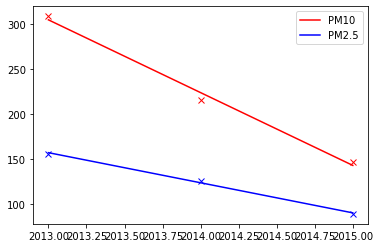

In [48]:
PlotBoth('Shijiazhuang')

In [50]:
def PlotCity(city: str, color, UsePM10):
    data = GetDataForCity(city, UsePM10, not UsePM10)
    if len(data) > 0:
        _ShowRegression(data.Year.values, data.Value.values, color, city)

def PlotMultiCities(cities:list, color:list, UsePM10 = True):
    for city, color in zip(cities, color):
        PlotCity(city, color, UsePM10)
    plt.legend()
    plt.show()

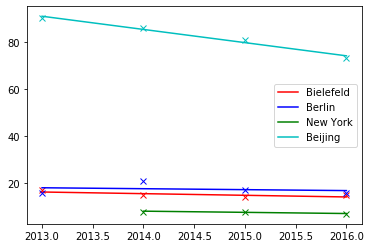

In [52]:
PlotMultiCities(['Bielefeld', 'Berlin', 'New York', 'Beijing'], ['r', 'b', 'g', 'c'], False)

### Rank by regression

In [75]:
def GetSlopeInterceptCity(city: str, usepm10, measuredonly, mindatapoints)->tuple:
    data = GetDataForCity(city, usepm10, not usepm10)
    if measuredonly:
        data = data.loc[data.Converted == False]
    if len(data) < mindatapoints:
        return False, 0, 0, city, ''
    else:
        slope, intercept, *rest = stats.stats.linregress(data.Year.values, data.Value.values)
        return True, slope, intercept, city, data.Country.values[0]

def GetSlopeInterceptAll(usepm10, measuredonly, mindatapoints)->list:
    return [(slope, intercept, city, country) for s, slope, intercept, city, country in _GetSlopeInterceptAll(usepm10, measuredonly, mindatapoints) if s]
def _GetSlopeInterceptAll(usepm10, measuredonly, mindatapoints)->list:
    return [GetSlopeInterceptCity(city, usepm10, measuredonly, mindatapoints) for city in GetCities()]

def PrintSlopeRanking(UsePM10, MeasuredOnly, Reverse, count = 15):
    print()
    data = GetSlopeInterceptAll(UsePM10, MeasuredOnly, 3)
    data.sort(key=lambda tup: tup[0], reverse=Reverse)
    data = data[:count]
    length = max([len('%s (%s)'  % (city, country)) for slope, intercept, city, country in data])
    valuelength = max([len('%.2f' % slope) for slope, intercept, city, country in data])
    numberlength = len(str(count))
    format = '%%%dd. %%%ds %%%ds' % (numberlength, length, valuelength)
    for i, cdata in enumerate(data):
        strvalue = '%.2f' % (cdata[0])
        print(format % (i+1, '%s (%s)'  % (cdata[2], cdata[3]), strvalue))


In [76]:
PrintSlopeRanking(False, False, True)


 1.            Pasakha (Bhutan) 19.90
 2.              Kanpur (India) 16.36
 3.       Riyadh (Saudi Arabia) 11.00
 4.              Nagpur (India) 10.30
 5.        Yanbu (Saudi Arabia)  9.20
 6.           Kanglung (Bhutan)  6.00
 7.    Slavonski Brod (Croatia)  5.43
 8.          Concepcion (Chile)  5.00
 9.                Agra (India)  4.61
10.       Pljevlja (Montenegro)  4.10
11.         Niksic (Montenegro)  4.00
12.            Ha Noi (Vietnam)  3.89
13. Comuna De Coyhaique (Chile)  3.78
14.            Valdivia (Chile)  3.60
15.        Vina Del Mar (Chile)  3.50


## Pie charts

In [83]:
def TotalStationCountperRegion()->dict:
    dictStation={}
    regionList=GetRegionList()
    for element in regionList:
        stationData=data.loc[data.Region==element]
        sumstation = 0
        for city in stationData.City.unique():
            sumstation += max(stationData.loc[stationData.City == city].Stationcount.values)

        dictStation[element]=sumstation
    return dictStation

def TotalStationCountperIncome()->dict:
    dictStationIncome={}
    incomeList=GetIncomeList()
    for element in incomeList:
        stationData=data.loc[data.Income==element]
        sumstation = 0
        for city in stationData.City.unique():
            sumstation += max(stationData.loc[stationData.City == city].Stationcount.values)
        dictStationIncome[element]=sumstation
    return dictStationIncome

def PlotStationCountPerRegion():
    dictStation=TotalStationCountperRegion()
    labels=GetRegionList()
    listValues=[*dictStation.values()]
    def helper(listValues):
        def helper2(pct):
            total=sum(listValues)
            value=int(round(pct*total/100.0))
            return '{p:.2f}%  ({v:d})'.format(p=pct,v=value)
        return helper2
    plt.pie(listValues,labels=labels,autopct=helper(listValues),radius=2.5)
    plt.title('Total Station Count per Region',pad=125, bbox={'facecolor':'0.8'})
    plt.show()
    
def PlotStationCountByIncome():
    dictStationIncome=TotalStationCountperIncome()
    labels=GetIncomeList()
    listValues=[*dictStationIncome.values()]
    def helper(listValues):
        def helper2(pct):
            total=sum(listValues)
            value=int(round(pct*total/100.0))
            return '{p:.2f}%  ({v:d})'.format(p=pct,v=value)
        return helper2
    plt.pie(listValues,labels=labels,autopct=helper(listValues),radius=2.5)
    plt.title('Total Station Count per Income',pad=125, bbox={'facecolor':'0.8'})
    plt.show()


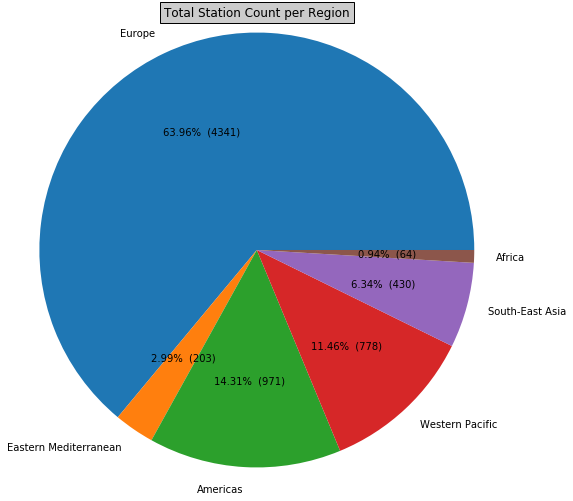

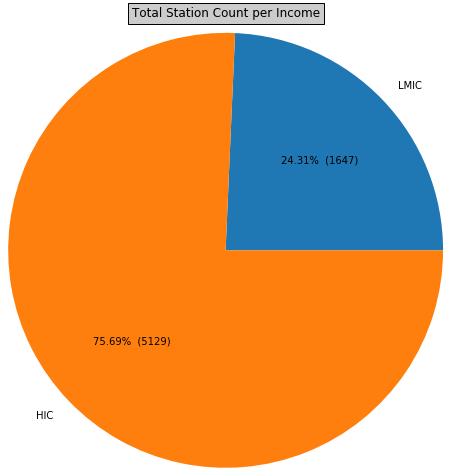

In [84]:
PlotStationCountPerRegion()
PlotStationCountByIncome()